Trying to implement Prioritezed Experience according to explanation from Thomas Simonini from [here](https://medium.freecodecamp.org/improvements-in-deep-q-learning-dueling-double-dqn-prioritized-experience-replay-and-fixed-58b130cc5682)

## Import the necessary library

In [1]:
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from unityagents import UnityEnvironment
from agents_maddpg.utils import OUNoise

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
env = UnityEnvironment(file_name="./Crawler_Windows_x86_64/Crawler.exe")
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

env_info = env.reset(train_mode=False)[brain_name]
num_agents = len(env_info.agents)
states = env_info.vector_observations
action_size = brain.vector_action_space_size
state_size = states.shape[1]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: CrawlerBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 129
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 20
        Vector Action descriptions: , , , , , , , , , , , , , , , , , , , 


## Method to plot the progress of the agent's score

In [3]:
def plot_result(scores):
    # plot the scores
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

In [4]:
def train(agent, n_episodes=500, noise = 1, noise_reduction=0.9999, train_mode=True):
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=train_mode)[brain_name]
        states = env_info.vector_observations
        scores_one_episode = np.zeros(num_agents)
        # reset the noise
        agent.reset()
        while True:
            actions = agent.act(states, noise=noise)              # select an action (for each agent)
                
            env_info = env.step(np.clip(actions, -1, 1))[brain_name]              # send all actions to the environment
            next_states = env_info.vector_observations                            # get next state (for each agent)
            rewards = env_info.rewards                                            # get reward (for each agent)
            # lets try to promote cooperation
            dones = env_info.local_done                                           # see if episode finished
            agent.step(states, actions, rewards, next_states, dones)       # learn
            states = next_states                                                  # roll over states to next time step
            
            scores_one_episode += rewards
            if np.any(dones):                                                     # exit loop if episode finished
                break
                
        noise = max(noise * noise_reduction, 0.01)        
        score = np.average(scores_one_episode)
        scores.append(score)
        scores_window.append(score)
        mean_100 = np.mean(scores_window)

        if i_episode % 50 == 0:
            print('\rEpisode {}\tAverage Score: {:.3f}\tMax Score: {:.3f}\tNoise: {:.3f}'.
                      format(i_episode, 
                         mean_100, 
                         np.max(scores_window),
                        noise))
            agent.save("eps_{}_avg_{}.pth".format(i_episode, mean_100))
            
        if len(scores_window) >= 100 and np.mean(scores_window)>=2000:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.3f}'.format(i_episode, mean_100))
            agent.save("final.pth")
            break
            
    return scores

## Prepare the agent
* One instance of the memory ReplayBuffer is built here
* The MADDPG is one version of the DDPG that use one local actor/critic network and one target actor/critic network that are being used by all agents.
* The hyperparameters are set and the agent is initialized
* Several instances of the noise generator are created and attached to the agent

In [5]:
from agents_maddpg.utils import ReplayBuffer, SimpleNoise
from agents_maddpg.maddpg import MADDPG
from agents_maddpg.model import ActorCritic
import torch.nn.functional as F
import random

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"
seed = 257
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
memory = ReplayBuffer(action_size, device, int(1e5), 256, seed)
agent = MADDPG(states.shape[1], action_size, states.shape[0], memory, ActorCritic, device,
                    GRADIENT_CLIP = 5,
                    ACTIVATION = F.relu,
                    TAU=1e-3,
                    UPDATE_EVERY=32,
                    TRANSFER_EVERY=1,
                    UPDATE_LOOP=16,
                    ADD_NOISE_EVERY=1,
                    BOOTSTRAP_SIZE=4,
                    LR_CRITIC = 3e-4,
                    LR_ACTOR = 3e-4)


In [6]:
agent.load("weights/eps_12250_avg_493.69921819451406.pth")
noises = [SimpleNoise(action_size, scale=1) for i in range(int(states.shape[1]))] 
agent.set_noise(noises)
scores = train(agent, n_episodes=60000, noise = 0.01, noise_reduction = 0.9996, train_mode=True)
plot_result(scores)

I:\MyDev\Anaconda3\envs\drlnd\lib\site-packages\torch\nn\functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 50	Average Score: 293.574	Max Score: 1177.837	Noise: 0.010
Episode 100	Average Score: 292.396	Max Score: 1177.837	Noise: 0.010
Episode 150	Average Score: 293.213	Max Score: 627.467	Noise: 0.010
Episode 200	Average Score: 299.065	Max Score: 650.084	Noise: 0.010
Episode 250	Average Score: 322.051	Max Score: 1202.594	Noise: 0.010
Episode 300	Average Score: 347.288	Max Score: 1202.594	Noise: 0.010
Episode 350	Average Score: 342.495	Max Score: 1019.814	Noise: 0.010
Episode 400	Average Score: 341.326	Max Score: 923.969	Noise: 0.010
Episode 450	Average Score: 358.104	Max Score: 963.005	Noise: 0.010
Episode 500	Average Score: 364.428	Max Score: 1124.668	Noise: 0.010
Episode 550	Average Score: 349.296	Max Score: 1225.531	Noise: 0.010
Episode 600	Average Score: 375.422	Max Score: 1225.531	Noise: 0.010
Episode 650	Average Score: 423.101	Max Score: 1148.760	Noise: 0.010
Episode 700	Average Score: 432.078	Max Score: 1221.634	Noise: 0.010
Episode 750	Average Score: 439.894	Max Score: 1221.63

I:\MyDev\Anaconda3\envs\drlnd\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Episode 2900	Average Score: nan	Max Score: nan	Noise: 0.010
Episode 2950	Average Score: nan	Max Score: nan	Noise: 0.010
Episode 3000	Average Score: -0.575	Max Score: -0.575	Noise: 0.010
Episode 3050	Average Score: -0.575	Max Score: -0.575	Noise: 0.010
Episode 3100	Average Score: -0.575	Max Score: -0.575	Noise: 0.010
Episode 3150	Average Score: -0.575	Max Score: -0.575	Noise: 0.010
Episode 3200	Average Score: -0.575	Max Score: -0.575	Noise: 0.010
Episode 3250	Average Score: -0.575	Max Score: -0.575	Noise: 0.010
Episode 3300	Average Score: -0.575	Max Score: -0.575	Noise: 0.010
Episode 3350	Average Score: -0.575	Max Score: -0.575	Noise: 0.010
Episode 3400	Average Score: -0.575	Max Score: -0.575	Noise: 0.010
Episode 3450	Average Score: -0.575	Max Score: -0.575	Noise: 0.010
Episode 3500	Average Score: -0.575	Max Score: -0.575	Noise: 0.010
Episode 3550	Average Score: -0.575	Max Score: -0.575	Noise: 0.010
Episode 3600	Average Score: -0.575	Max Score: -0.575	Noise: 0.010
Episode 3650	Average S

KeyboardInterrupt: 

In [ ]:
agent.load("weights/MADDPG/eps_2850_avg_570.9131032581789.pth")
noises = [SimpleNoise(action_size, scale=1) for i in range(int(states.shape[1]))] 
agent.set_noise(noises)
scores = train(agent, n_episodes=60000, noise = 1, noise_reduction = 0.99996, train_mode=True)
plot_result(scores)

I:\MyDev\Anaconda3\envs\drlnd\lib\site-packages\torch\nn\functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 50	Average Score: 10.178	Max Score: 20.448	Noise: 0.998
Episode 100	Average Score: 9.448	Max Score: 25.383	Noise: 0.996
Episode 150	Average Score: 8.394	Max Score: 25.383	Noise: 0.994
Episode 200	Average Score: 10.049	Max Score: 31.791	Noise: 0.992
Episode 250	Average Score: 11.954	Max Score: 31.791	Noise: 0.990
Episode 300	Average Score: 12.257	Max Score: 39.518	Noise: 0.988
Episode 350	Average Score: 12.863	Max Score: 39.518	Noise: 0.986
Episode 400	Average Score: 13.739	Max Score: 40.364	Noise: 0.984
Episode 450	Average Score: 12.692	Max Score: 40.364	Noise: 0.982
Episode 500	Average Score: 11.308	Max Score: 29.803	Noise: 0.980
Episode 550	Average Score: 11.709	Max Score: 30.133	Noise: 0.978
Episode 600	Average Score: 11.788	Max Score: 32.765	Noise: 0.976
Episode 650	Average Score: 12.685	Max Score: 32.765	Noise: 0.974
Episode 700	Average Score: 14.128	Max Score: 29.359	Noise: 0.972
Episode 750	Average Score: 14.583	Max Score: 37.219	Noise: 0.970
Episode 800	Average Score: 1

Episode 6300	Average Score: 29.812	Max Score: 93.044	Noise: 0.777
Episode 6350	Average Score: 31.909	Max Score: 93.044	Noise: 0.776
Episode 6400	Average Score: 29.951	Max Score: 82.130	Noise: 0.774
Episode 6450	Average Score: 31.074	Max Score: 86.401	Noise: 0.773
Episode 6500	Average Score: 32.366	Max Score: 135.530	Noise: 0.771
Episode 6550	Average Score: 35.743	Max Score: 135.530	Noise: 0.770
Episode 6600	Average Score: 38.630	Max Score: 106.934	Noise: 0.768
Episode 6650	Average Score: 35.609	Max Score: 135.522	Noise: 0.766
Episode 6700	Average Score: 34.026	Max Score: 135.522	Noise: 0.765
Episode 6750	Average Score: 35.063	Max Score: 99.647	Noise: 0.763
Episode 6800	Average Score: 35.541	Max Score: 165.014	Noise: 0.762
Episode 6850	Average Score: 35.682	Max Score: 165.014	Noise: 0.760
Episode 6900	Average Score: 34.070	Max Score: 77.065	Noise: 0.759
Episode 6950	Average Score: 35.514	Max Score: 122.057	Noise: 0.757
Episode 7000	Average Score: 38.370	Max Score: 174.920	Noise: 0.756
E

## Continue the training with small noise

Episode 50	Average Score: 0.127	Max Score: 1.400	Noise: 0.010
Episode 100	Average Score: 0.113	Max Score: 1.400	Noise: 0.010
Episode 150	Average Score: 0.099	Max Score: 0.200	Noise: 0.010
Episode 200	Average Score: 0.114	Max Score: 1.200	Noise: 0.010
Episode 250	Average Score: 0.120	Max Score: 1.200	Noise: 0.010
Episode 300	Average Score: 0.103	Max Score: 0.300	Noise: 0.010
Episode 350	Average Score: 0.093	Max Score: 0.300	Noise: 0.010
Episode 400	Average Score: 0.095	Max Score: 0.900	Noise: 0.010
Episode 450	Average Score: 0.088	Max Score: 0.900	Noise: 0.010
Episode 500	Average Score: 0.087	Max Score: 0.200	Noise: 0.010
Episode 550	Average Score: 0.095	Max Score: 0.200	Noise: 0.010
Episode 600	Average Score: 0.096	Max Score: 0.100	Noise: 0.010
Episode 650	Average Score: 0.100	Max Score: 0.200	Noise: 0.010
Episode 700	Average Score: 0.151	Max Score: 2.000	Noise: 0.010
Episode 750	Average Score: 0.156	Max Score: 2.000	Noise: 0.010
Episode 800	Average Score: 0.151	Max Score: 2.600	Noise:

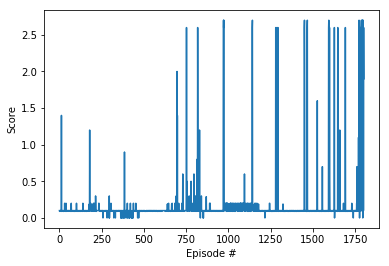

In [22]:
scores = train(agent, n_episodes=2000, noise = 0.01, noise_reduction = 0.9996, train_mode=True)
plot_result(scores)

## View the trained agent

In [5]:
from agents.model import ActorCritic
import torch.nn.functional as F
device = "cpu"
network = ActorCritic(state_size, action_size, state_size * 2 , F.leaky_relu ).to(device)
network.eval()
network.load_state_dict(torch.load("./final_weights/final_maddpg_local.pth"))
env_info = env.reset(train_mode=False)[brain_name]

def act(network, states, device):
    states = torch.from_numpy(states).float().unsqueeze(0).to(device)
    ret = network(states).squeeze().cpu().data.numpy()
    return ret

for i in range(5):
    while True:
        actions = act(network, states, device)
        env_info = env.step(np.clip(actions, -1, 1))[brain_name]  # send all actions to the environment
        states = env_info.vector_observations                     # get next state (for each agent)
        dones = env_info.local_done                               # see if episode finished
        if np.any(dones):                                         # exit loop if episode finished
            break